# Kaggle: Zillow Prize

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import Imputer
import missingno as msno
import re
from sklearn.base import TransformerMixin
%matplotlib inline

In [2]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

## Importing datasets

In [3]:
properties_path = 'https://s3.us-east-2.amazonaws.com/aws-emr-dedicated/data/zillow/properties_2016.csv'
train_path = 'https://s3.us-east-2.amazonaws.com/aws-emr-dedicated/data/zillow/train_2016_v2.csv'

properties = pd.read_csv(filepath_or_buffer=properties_path)
train = pd.read_csv(filepath_or_buffer=train_path)

/Applications/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
properties.set_index('parcelid', inplace=True)
properties['latitude'] = properties['latitude']/1e6
properties['longitude'] = properties['longitude']/1e6

In [5]:
properties_in_train_origin = properties.loc[train['parcelid'].drop_duplicates()]

In [6]:
properties_in_train = properties_in_train_origin.copy()
include_properties=True
tables = []
if include_properties:
    tables = [properties_in_train, properties]
else:
    tables = [properties_in_train]
print(properties.shape)
print(train.shape)
print(properties_in_train.shape)

(2985217, 57)
(90275, 3)
(90150, 57)


## Visualization of missing values

In [7]:
enable_visualization=False

In [8]:
properties_in_train['numberofstories'].value_counts(dropna=False)

NaN     69610
 1.0    11997
 2.0     8034
 3.0      507
 4.0        2
Name: numberofstories, dtype: int64

In [9]:
# missing percentage
print(properties.shape)
properties.count().sort_values() / properties.shape[0]

(2985217, 57)


storytypeid                     0.000544
basementsqft                    0.000545
yardbuildingsqft26              0.000887
fireplaceflag                   0.001730
architecturalstyletypeid        0.002030
typeconstructiontypeid          0.002260
finishedsquarefeet13            0.002570
buildingclasstypeid             0.004231
decktypeid                      0.005727
finishedsquarefeet6             0.007370
poolsizesum                     0.009366
pooltypeid2                     0.010745
pooltypeid10                    0.012374
taxdelinquencyflag              0.018914
taxdelinquencyyear              0.018915
hashottuborspa                  0.023119
yardbuildingsqft17              0.026918
finishedsquarefeet15            0.063914
finishedsquarefeet50            0.067907
finishedfloor1squarefeet        0.067907
threequarterbathnbr             0.104391
fireplacecnt                    0.104728
pooltypeid7                     0.162621
poolcnt                         0.173366
numberofstories 

In [10]:
if enable_visualization:
    colnames = properties_in_train.count().sort_values().index
    msno.matrix(msno.nullity_sort(properties_in_train[colnames], sort='descending'), labels=True)

In [11]:
# Correlation
if enable_visualization:
    import seaborn as sns
    from matplotlib import pyplot as plt

    plt.figure(figsize=(20,15))
    corr = properties_in_train.corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Preprocessing data

In [12]:
drop_cols = [
    'fips', # fips is identical to regionidcounty
    'censustractandblock', # identical to rawcensustractandblock
#    'propertyzoningdesc',
#    'rawcensustractandblock',
#    'regionidcity',
#    'regionidneighborhood',
#    'regionidzip',
    'assessmentyear', # same year
    'taxdelinquencyyear', # represented by tax delinquency year
#    'buildingclasstypeid',
    'finishedsquarefeet13',
    'basementsqft',
#    'storytypeid',
#    'yardbuildingsqft26',
    'fireplaceflag',
    'finishedsquarefeet6',
    'finishedfloor1squarefeet',
    'finishedsquarefeet50',
    'finishedsquarefeet12',
    'finishedsquarefeet15',
    'calculatedbathnbr',
    'fullbathcnt',
    'calculatedbathnbr',
    'threequarterbathnbr',
    'yardbuildingsqft26',
    'yardbuildingsqft17',
    'landtaxvaluedollarcnt',
    'structuretaxvaluedollarcnt',
    'pooltypeid10',
    'pooltypeid7',
    'pooltypeid2',
    'poolcnt',
    'fireplacecnt',
    'garagecarcnt',
    'bedroomcnt',
    'buildingclasstypeid',
    'storytypeid',
    'architecturalstyletypeid',
    'typeconstructiontypeid',
    'decktypeid'
]

string_categorical_cols = [
    'hashottuborspa'
    ,'propertycountylandusecode'
    ,'taxdelinquencyflag'
    ,'propertyzoningdesc'
    
]


In [13]:
for table in tables:
    table['fullbathcnt'].fillna(0, inplace=True)
    table['threequarterbathnbr'].fillna(0, inplace=True)
    table['yardbuildingsqft17'].fillna(0, inplace=True)
    table['yardbuildingsqft26'].fillna(0, inplace=True)
    table['unitcnt'].fillna(0, inplace=True)
    table['taxdelinquencyflag'].fillna('N', inplace=True)
    table['poolcnt'].fillna(0, inplace=True)
    table['fireplacecnt'].fillna(0, inplace=True)
    table['garagecarcnt'].fillna(0, inplace=True)
    table['bedroomcnt'].fillna(0, inplace=True)
    table['pooltypeid10'].fillna(0, inplace=True)
    table['pooltypeid7'].fillna(0, inplace=True)
    table['pooltypeid2'].fillna(0, inplace=True)
    table['poolsizesum'].fillna(0, inplace=True)
    table['hashottuborspa'].fillna('False', inplace=True)
    table['yearbuilt'].fillna(0, inplace=True)
    
    table['bathroomcnt'] = table['fullbathcnt']+table['threequarterbathnbr']*.5
    table['yardbuildingsqft'] = table['yardbuildingsqft17']+table['yardbuildingsqft26']
    table['roomcnt'] = table['poolcnt']*2 + \
    table['fireplacecnt']*.5 + \
    table['garagecarcnt']*1 + \
    table['bedroomcnt']*2
    table['pooltypeid'] = table['pooltypeid10']*10 + \
    table['pooltypeid7']*7 + \
    table['pooltypeid2']*2



In [14]:
# Drop Columns
for table in tables:
    print(table.shape)
    for col in table.columns:
    # drop columns
        if col in drop_cols:
            print('Dropping {}...'.format(col))
            table.drop(col, axis=1, inplace=True)
print('done!') 

(90150, 59)
Dropping architecturalstyletypeid...
Dropping basementsqft...
Dropping bedroomcnt...
Dropping buildingclasstypeid...
Dropping calculatedbathnbr...
Dropping decktypeid...
Dropping finishedfloor1squarefeet...
Dropping finishedsquarefeet12...
Dropping finishedsquarefeet13...
Dropping finishedsquarefeet15...
Dropping finishedsquarefeet50...
Dropping finishedsquarefeet6...
Dropping fips...
Dropping fireplacecnt...
Dropping fullbathcnt...
Dropping garagecarcnt...
Dropping poolcnt...
Dropping pooltypeid10...
Dropping pooltypeid2...
Dropping pooltypeid7...
Dropping storytypeid...
Dropping threequarterbathnbr...
Dropping typeconstructiontypeid...
Dropping yardbuildingsqft17...
Dropping yardbuildingsqft26...
Dropping fireplaceflag...
Dropping structuretaxvaluedollarcnt...
Dropping assessmentyear...
Dropping landtaxvaluedollarcnt...
Dropping taxdelinquencyyear...
Dropping censustractandblock...
(2985217, 59)
Dropping architecturalstyletypeid...
Dropping basementsqft...
Dropping bedroo

In [15]:
# categorical columns
numerical_categorical_cols = [x for x in properties_in_train.columns if re.search('id$', x)]

categorical_cols = string_categorical_cols + numerical_categorical_cols
print(categorical_cols)

['hashottuborspa', 'propertycountylandusecode', 'taxdelinquencyflag', 'propertyzoningdesc', 'airconditioningtypeid', 'buildingqualitytypeid', 'heatingorsystemtypeid', 'propertylandusetypeid', 'pooltypeid']


In [16]:
#properties_in_train['fireplaceflag'].value_counts(dropna=False)

In [17]:
from sklearn import preprocessing

for col_name in string_categorical_cols:
    print('preprocessing {}...'.format(col_name))
    # create a LabelEncoder instance
    encoder = preprocessing.LabelEncoder()
    # fit LabelEncoder
    if include_properties:
        encoder.fit(properties[col_name].astype(str))
    else:
        encoder.fit(properties_in_train[col_name].astype(str))
    # transform training set & test set based on training set
    properties_in_train[col_name] = encoder.transform(properties_in_train[col_name].astype(str))
    if include_properties:
        properties[col_name] = encoder.transform(properties[col_name].astype(str))
print('done!') 

preprocessing hashottuborspa...
preprocessing propertycountylandusecode...
preprocessing taxdelinquencyflag...
preprocessing propertyzoningdesc...
done!


In [18]:
def categoryFilter(fit_data, transform_data=[], cols=[], fillna=None):
    for t_data in transform_data:
        for col in cols:
            levels = fit_data.loc[~fit_data[col].isnull(), col].unique()
            t_data.loc[~t_data[col].isin(levels), col] = np.nan
            t_data[col] = t_data[col]
        if fillna is not None:
            t_data = t_data.fillna(fillna)
        yield t_data

In [19]:
for col in properties_in_train.columns:
    print('preprocessing {}...'.format(col))
    # fix categorical levels
    if col in categorical_cols:
        if include_properties:
            properties_in_train, properties = categoryFilter(
                fit_data=properties_in_train, 
                transform_data=[properties_in_train,properties], 
                cols=[col], 
                fillna=-1
            )
print('done!') 
#drop the column is the drop list
#fix the discrepencies of levels in training and testing datasets

preprocessing airconditioningtypeid...
preprocessing bathroomcnt...
preprocessing buildingqualitytypeid...
preprocessing calculatedfinishedsquarefeet...
preprocessing garagetotalsqft...
preprocessing hashottuborspa...
preprocessing heatingorsystemtypeid...
preprocessing latitude...
preprocessing longitude...
preprocessing lotsizesquarefeet...
preprocessing poolsizesum...
preprocessing propertycountylandusecode...
preprocessing propertylandusetypeid...
preprocessing propertyzoningdesc...
preprocessing rawcensustractandblock...
preprocessing regionidcity...
preprocessing regionidcounty...
preprocessing regionidneighborhood...
preprocessing regionidzip...
preprocessing roomcnt...
preprocessing unitcnt...
preprocessing yearbuilt...
preprocessing numberofstories...
preprocessing taxvaluedollarcnt...
preprocessing taxamount...
preprocessing taxdelinquencyflag...
preprocessing yardbuildingsqft...
preprocessing pooltypeid...
done!


In [20]:
# imp = DataFrameImputer()

# imp.fit(properties_in_train)
# properties_in_train = imp.transform(properties_in_train)
# properties = imp.transform(properties)

# impute na with -1 for numeric positive values
properties_in_train.fillna(-1, inplace=True)
if include_properties:
    properties.fillna(-1, inplace=True)

In [21]:
properties_in_train.dtypes

airconditioningtypeid           float64
bathroomcnt                     float64
buildingqualitytypeid           float64
calculatedfinishedsquarefeet    float64
garagetotalsqft                 float64
hashottuborspa                  float64
heatingorsystemtypeid           float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
poolsizesum                     float64
propertycountylandusecode       float64
propertylandusetypeid           float64
propertyzoningdesc              float64
rawcensustractandblock          float64
regionidcity                    float64
regionidcounty                  float64
regionidneighborhood            float64
regionidzip                     float64
roomcnt                         float64
unitcnt                         float64
yearbuilt                       float64
numberofstories                 float64
taxvaluedollarcnt               float64
taxamount                       float64


## Outlier Elimination

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

def mad_based_outlier(points, thresh=4.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=99):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

def abs_value_outlier(data, threshold=4):
    return (data < -threshold) | (data > threshold)

def plot(x, outliers):
    kwargs = dict(y=0.95, x=0.05, ha='left', va='top')
    fig, axes = plt.subplots(nrows=2)
    for ax, outlier_type in zip(axes, outliers):
        sns.distplot(x, ax=ax, rug=False, hist=True, kde=False)
        outlier_vals = x[outliers[outlier_type]]
        ax.plot(outlier_vals, np.ones_like(outlier_vals), 'ro', clip_on=False)
        ax.set_yscale("log")
        ax.set_title(outlier_type+'-based Outliers', **kwargs)

    #axes[0].set_title('Percentile-based Outliers', **kwargs)
    #axes[1].set_title('MAD-based Outliers', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=14)

Calculating adhoc-abs based outliers...
6416    -4.605
7318     4.737
22475    4.445
22476    4.520
69228   -4.605
88788   -4.510
Name: logerror, dtype: float64
Calculating mad based outliers...
5       -0.2705
10       0.3825
93      -0.2459
102     -0.4095
121      0.3358
124     -0.6368
132     -0.4277
158      0.3825
184     -0.3439
212      0.4941
222     -0.2144
277     -0.4080
281      0.4929
293      1.0830
303     -0.4277
313     -0.2971
315      0.2624
382     -0.2549
463     -0.3425
470      0.3968
472      0.3141
475      0.2508
494      0.7453
495     -0.3552
521      0.2500
541     -0.2485
547      0.3478
569      0.2776
592     -0.2169
601     -0.2497
          ...  
89850    0.9451
89871   -0.2824
89935    0.3764
89941   -0.5465
89944    0.2837
89960   -0.4668
89972    0.3045
89983   -0.2357
90030   -0.2549
90057   -0.2421
90075    0.3008
90079    0.2515
90081    0.3322
90086   -0.2408
90096    0.2492
90107   -0.2332
90129    0.3716
90148   -0.2998
90169    0.2994
90176

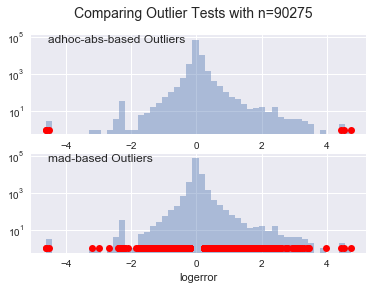

In [73]:
#funcs = {'percentile':percentile_based_outlier, 'mad':mad_based_outlier}
funcs = {'adhoc-abs':abs_value_outlier, 'mad':mad_based_outlier}

def calc_outliers(x, funcs):
    outliers = {}
    for func in funcs:
        print('Calculating {} based outliers...'.format(func))
        outliers[func] = funcs[func](x)
        print(x[outliers[func]])
    return outliers

outliers = calc_outliers(train['logerror'], funcs)
plot(train['logerror'], outliers)
plt.show()

In [ ]:
train.drop(col, axis=1, inplace=True)

## Data Preparation

In [64]:
train_set = pd.merge(
    properties_in_train.dropna(axis=1), 
    train, 
    left_index = True, 
    right_on='parcelid'
)
train_set['month'] = pd.to_datetime(train_set['transactiondate']).dt.month
train_set = train_set.drop('parcelid', axis=1).drop('transactiondate', axis=1)

In [65]:
X = train_set.drop('logerror', axis=1)
y = train_set['logerror']

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0)

## Cross Validation

### Linear Regressor

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model

parameters = {'l1_ratio':np.arange(0.0, 0.1, 0.01),'alpha':np.logspace(-2, 2, 100),'normalize':[True]}

glm_reg = linear_model.ElasticNet()
glm_cv = GridSearchCV(glm_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=3)  
glm_cv.fit(X_train, y_train)

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda

GridSearchCV(cv=3, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([ 0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09]), 'alpha': array([  1.00000e-02,   1.09750e-02, ...,   9.11163e+01,   1.00000e+02]), 'normalize': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [82]:
def feature_importance_coef(estimator, labels):
    feature_imp = pd.DataFrame.from_dict({'feature':labels,
                                          'importance':estimator.coef_})
    feature_imp.set_index('feature',
                          inplace=True, 
                          drop=True)
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    feature_imp.plot.bar()

In [83]:
print(glm_cv.best_estimator_.alpha)
print('---')
print(glm_cv.best_estimator_.l1_ratio)

0.01
---
0.0


In [84]:
pd.DataFrame.from_dict({'feature':X_train.columns,'importance':glm_cv.best_estimator_.coef_})

,feature,importance
0,airconditioningtypeid,6.041635e-07
1,bathroomcnt,6.671642e-06
2,buildingqualitytypeid,-6.029679e-07
3,calculatedfinishedsquarefeet,1.013969e-08
4,garagetotalsqft,1.128006e-08
5,hashottuborspa,-8.597620e-06
6,heatingorsystemtypeid,-1.198410e-06
7,latitude,1.724590e-06
8,longitude,1.040376e-06
9,lotsizesquarefeet,1.168952e-11


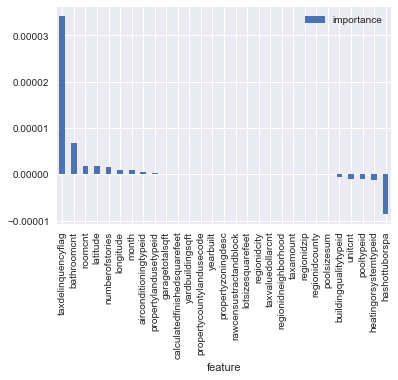

In [85]:
plt.figure(figsize=(20,15))
feature_importance_coef(glm_cv.best_estimator_, X_train.columns)

In [87]:
from sklearn.metrics import mean_absolute_error
#train error
print('glm - train error:')
print(mean_absolute_error(y_train, glm_cv.best_estimator_.predict(X_train)))

#test error
print('glm - test error:')
print(mean_absolute_error(y_test, glm_cv.best_estimator_.predict(X_test)))

# # 1st try
#l-ratio,0,1,0.3
# alpha, e-2,e2,100
# glm - train error:
# 0.0687201901119
# glm - test error:
# 0.0678291373718

#2nd try with 20~column
# glm - train error:
# 0.06872194546
# glm - test error:
# 0.0678310273739

glm - train error:
0.06872194546
glm - test error:
0.0678310273739


### Test Linear Model

In [33]:
gb_final = linear_model.ElasticNet(**glm_cv.best_params_)
gb_final.fit(X, y)

/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/ssss/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=1000, normalize=True, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [34]:
test_set = properties
test_set['month'] = 11
test_pred = gb_final.predict(test_set)

prediction = pd.DataFrame.from_dict({'index':test_set.index,
                                     'predict':test_pred})
prediction.set_index('index')

prediction.columns=['ParcelId','201610']
prediction['201611']=prediction['201610']
prediction['201612']=prediction['201610']
prediction['201710']=0
prediction['201711']=0
prediction['201712']=0
prediction=prediction.round(4)
from pandas import ExcelWriter

# DF TO CSV
prediction.to_csv('PythonExport_linear_2.csv', sep=',',index=False)

ValueError: shapes (2985217,60) and (29,) not aligned: 60 (dim 1) != 29 (dim 0)

### [RandomForestRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[5,10,20],'n_jobs':[-1],'oob_score':[False]}

rf_reg = RandomForestRegressor(verbose=1)
rf_cv = GridSearchCV(rf_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=3)  
rf_cv.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_job

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=1, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20], 'n_jobs': [-1], 'oob_score': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [303]:
# best cv parameters
print(rf_cv.best_params_)

{'n_estimators': 20, 'n_jobs': -1, 'oob_score': False}


In [304]:
def feature_importance(estimator, labels):
    feature_imp = pd.DataFrame.from_dict({'feature':labels,
                                          'importance':estimator.feature_importances_})
    feature_imp.set_index('feature',
                          inplace=True, 
                          drop=True)
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    feature_imp.plot.bar()

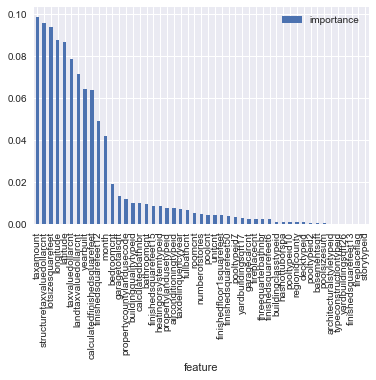

In [223]:
feature_importance(rf_cv.best_estimator_, X_train.columns)

### old test error --DO NOT CHANGE

In [89]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, rf_cv.best_estimator_.predict(X_test))
#0.077428253006117595 origin

[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished


0.077534167378030733

### new error from modified features - CHECK overfitting/underfitting

In [90]:
#train error
print('rf - train error:')
print(mean_absolute_error(y_train, rf_cv.best_estimator_.predict(X_train)))

#test error
print('rf - test error:')
print(mean_absolute_error(y_test, rf_cv.best_estimator_.predict(X_test)))

# 0.0311793544926
# rf - test error:
# 0.077534167378
#overfit

rf - train error:


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.0s finished


0.0311793544926
rf - test error:
0.077534167378


#### GradientBoostingRegressor

In [91]:
from sklearn.ensemble import GradientBoostingRegressor

parameters = {'n_estimators':[5, 10, 20],
              'learning_rate':[0.01, 0.1],
              'max_depth':[1,3,5]
             }

gb_reg = GradientBoostingRegressor(verbose=1)

gb_cv = GridSearchCV(gb_reg,
                     param_grid=parameters,
                     scoring='neg_mean_absolute_error',
                     cv=3)  
gb_cv.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.0260            0.05s
         2           0.0260            0.04s
         3           0.0260            0.03s
         4           0.0260            0.01s
         5           0.0260            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0254            0.05s
         2           0.0254            0.04s
         3           0.0254            0.03s
         4           0.0254            0.01s
         5           0.0254            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0257            0.05s
         2           0.0257            0.04s
         3           0.0257            0.03s
         4           0.0257            0.01s
         5           0.0257            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0260            0.12s
         2           0.0260            0.10s
         3           0.0260            0.09s
      

         2           0.0254            0.29s
         3           0.0253            0.19s
         4           0.0253            0.09s
         5           0.0253            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0257            0.44s
         2           0.0257            0.31s
         3           0.0257            0.21s
         4           0.0256            0.10s
         5           0.0256            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0260            0.84s
         2           0.0260            0.79s
         3           0.0260            0.71s
         4           0.0259            0.59s
         5           0.0259            0.50s
         6           0.0259            0.40s
         7           0.0259            0.30s
         8           0.0259            0.20s
         9           0.0259            0.10s
        10           0.0259            0.00s
      Iter       Train Loss   Remaining Time 
       

      Iter       Train Loss   Remaining Time 
         1           0.0259            0.40s
         2           0.0259            0.37s
         3           0.0258            0.33s
         4           0.0258            0.28s
         5           0.0257            0.24s
         6           0.0257            0.19s
         7           0.0257            0.15s
         8           0.0256            0.10s
         9           0.0256            0.05s
        10           0.0256            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0253            0.45s
         2           0.0252            0.40s
         3           0.0252            0.33s
         4           0.0251            0.28s
         5           0.0251            0.24s
         6           0.0250            0.19s
         7           0.0250            0.14s
         8           0.0249            0.10s
         9           0.0249            0.05s
        10           0.0248            0.00s
      It

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=1,
             warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20], 'learning_rate': [0.01, 0.1], 'max_depth': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [94]:
print(gb_cv.best_params_)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20}


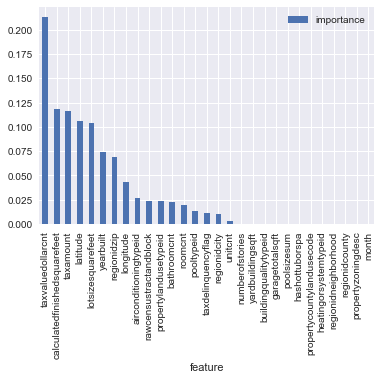

In [96]:
def feature_importance(estimator, labels):
    feature_imp = pd.DataFrame.from_dict({'feature':labels,
                                          'importance':estimator.feature_importances_})
    feature_imp.set_index('feature',
                          inplace=True, 
                          drop=True)
    feature_imp = feature_imp.sort_values('importance', ascending=False)
    feature_imp.plot.bar()
    
feature_importance(gb_cv.best_estimator_, X_train.columns)

### old test error  --DO NOT CHANGE

In [309]:
mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test))
#0.067493329273472222 origin

0.067493329273472222

### new error from modified features  - CHECK overfitting/underfitting

In [97]:
#train error
print('gbm - train error:')
print(mean_absolute_error(y_train, gb_cv.best_estimator_.predict(X_train)))

#test error
print('gbm - test error:')
print(mean_absolute_error(y_test, gb_cv.best_estimator_.predict(X_test)))

gbm - train error:
0.0681052577268
gbm - test error:
0.0674683525648


## Final model fit

In [98]:
gb_final = GradientBoostingRegressor(**gb_cv.best_params_)

In [99]:
gb_final.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=20, presort='auto',
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

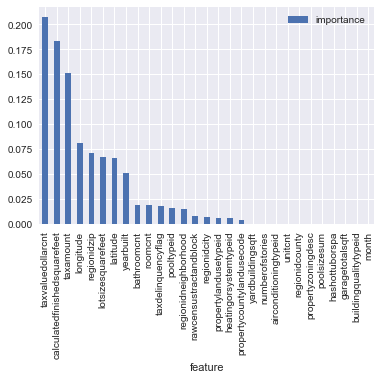

In [100]:
feature_importance(gb_final, X.columns)

In [101]:
test_set = properties
test_set['month'] = 11

test_pred = gb_final.predict(test_set)

In [102]:
prediction = pd.DataFrame.from_dict({'index':test_set.index,
                                     'predict':test_pred})
prediction.set_index('index')

,predict
index,
10754147,0.643683
10759547,0.300711
10843547,0.397818
10859147,0.152704
10879947,0.011226
10898347,0.017476
10933547,0.004267
10940747,0.026865
10954547,0.643683


In [103]:
prediction.columns=['ParcelId','201610']
prediction['201611']=prediction['201610']
prediction['201612']=prediction['201610']
prediction['201710']=0
prediction['201711']=0
prediction['201712']=0

In [108]:
prediction=prediction.round(4)

In [105]:
from pandas import ExcelWriter

# DF TO CSV
prediction.to_csv('PythonExport_20cols.csv', sep=',',index=False)

In [107]:
prediction.shape

(2985217, 7)